In [264]:
import pandas as pd
import numpy as np
import random
import scipy
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)


<a id='ab'></a>
##  A/B тестирование

A/B-тестирование (англ. A/B testing, Split testing) — метод маркетингового исследования, суть которого заключается в том, что контрольная группа элементов сравнивается с набором тестовых групп, в которых один или несколько показателей были изменены, для того, чтобы выяснить, какие из изменений улучшают целевой показатель и улучшают ли.

Конверсия (Conversion Rate) в интернет-маркетинге — это отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия (покупку, регистрацию, подписку, посещение определённой страницы сайта, переход по рекламной ссылке), к общему числу посетителей сайта, выраженное в процентах. 

Этапы A/B тестирования:

- Выдвигаем предположение о том, что какое-то изменение (например, персонализация главной страницы) увеличит конверсию интернет-магазина.

- Создаем альтернативную версию сайта «Б» — копию исходной версии «А» с изменениями, от которых мы ждем роста эффективности сайта.

- Всех посетителей сайта случайным образом делим на две равные группы: одной группе показываем исходный вариант (контрольная группа) , второй группе (тестовой) — альтернативный. Одновременно измеряем конверсию для обеих версий сайта.

- Определяем статистически достоверно победивший вариант.

# Домашнее задание №8

Провести анализ результатов A/B тестирования двух версий дизайна кнопки сайта интернет-магазина. Целевое действие: клик по кнопке. 

Результаты этапов 1-3 A/B-тестирования собраны в ab_dataset.csv.

Выполним пункт 4 -- определим статистически достоверно победивший вариант. Для этого проведем исследование чека и выясним, изменился ли средний чек.

## Решение

[1. Первичный анализ данных](#part1) \
[2. Формулировка и проверка гипотезы](#part2) \
[3. Статистические выводы](#part3)

### 1. Первичный анализ данных <a class="anchor" id="part1"></a><center>

Загрузим данные из файла ab_datas.csv

In [265]:
df = pd.read_csv('ab_datas.csv')
df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


Определим число посетителей сайта

In [266]:
#количество посетителей всего
n_rows = df.shape[0]
print("Число строк: {}".format(n_rows))

Число строк: 294478


Определим число уникальных посетителей сайта

In [267]:
#количество уникальных посетителей всего
user_total = df.nunique()['user_id']
print("Число уникальных пользователей : {}".format(user_total))

Число уникальных пользователей : 290584


Определим ошибки в распределении посетителей из контрольной группы на страницу в старом дизайне и пользователей из тестовой группы - на страницу в новом дизайне

In [268]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Из тестовой группы неверно направлены {}".format(len(mismatch_1)) + " пользователей")

mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Из контрольной группы неверно направлены  {}".format(len(mismatch_2)) + " пользователей")


Из тестовой группы неверно направлены 1965 пользователей
Из контрольной группы неверно направлены  1928 пользователей


Определяем, что пропусков в данных нет

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   revenue       294478 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


Вычислим средний чек по всем посетителям

In [270]:
print(f"Средний чек по всем посетителям: {df['revenue'].mean()}")

Средний чек по всем посетителям: 101.9677191504968


Описательная статистика датасета 

In [271]:
df_grp = df.groupby('group')['revenue']
df_grp.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,147202.0,87.431896,102.424926,0.0,0.0,0.0,250.0,250.0
treatment,147276.0,116.496238,102.732069,0.0,0.0,100.0,250.0,250.0


Средний чек в контрольной и тестовой группах имеет заментную разницу. Медианные значения revenue существенно отличаются в группах.

Выясним какова вероятность совершения покупки для посетителей из контрольной группы (старый дизайн)

In [272]:
#число пользователей контрольной группы, совершившие покупки
len(df.query("group == 'control' and revenue != 0"))
#число пользователей контрольной группы (объем контрольной группы)
n_rows_contr = len(df[df['group'] == 'control'])
#вероятность совершения покупки для посетителей из контрольной группы
p_cont = len(df.query("group == 'control' and revenue != 0")) / n_rows_contr 
print(f'Вероятность совершения покупки пользователем из контрольной группы: \n {p_cont}')

Вероятность совершения покупки пользователем из контрольной группы: 
 0.498641322808114


Определим какова вероятность совершения покупки для посетителей из тестовой группы (новый дизайн кнопки)

In [273]:
#число пользователей тестовой группы, совершившие покупки
len(df.query("group == 'treatment' and revenue != 0"))
#число пользователей тестовой группы (объем тестовой группы)
n_rows_treat = len(df[df['group'] == 'treatment'])
#вероятность совершения покупки для посетителей из тестовой группы
p_treat = len(df.query("group == 'treatment' and revenue != 0")) / n_rows_treat 
print(f'Вероятность совершения покупки пользователем из тестовой группы: \n {p_treat}')

Вероятность совершения покупки пользователем из тестовой группы: 
 0.665940139601836


Вероятность совершения покупки пользователем из тестовой группы больше.

Выясним каково соотношение размеров тестовой и контрольный групп; какова вероятность, что очередной посетитель будет направлен на версию со старым/новым дизайном

In [274]:
print("Соотношение размеров тестовой и контрольной групп: \n {}".format(n_rows_treat/n_rows_contr))

print("Вероятность, что новый пользователь будет направлен на версию со старым дизайном: \n {}".format(n_rows_treat/n_rows))
print("Вероятность, что новый пользователь будет направлен на версию с новым дизайном: \n {}".format(n_rows_contr/n_rows))

Соотношение размеров тестовой и контрольной групп: 
 1.0005027105609978
Вероятность, что новый пользователь будет направлен на версию со старым дизайном: 
 0.5001256460584492
Вероятность, что новый пользователь будет направлен на версию с новым дизайном: 
 0.49987435394155083


**Вывод:** поскольку объемы контрольной и тестовой групп примерно равны, средние значения чеков в каждой из групп имеют заметную разницу, то на основе предварительного анализа можно предположить, что новый дизайн сайта увеличивает вероятность совершения покупки и влечет за собой увеличение среднего чека.

### 2. Формулировка и проверка гипотезы <a class="anchor" id="part2"></a><center>

**2.1. Проверка гипотезы о равенстве генеральных средних двух выборок средствами python** 

Еще раз сравним средние значения чеков в выборках (контрольной и тестовой группе)

In [275]:
contr_mean = df.query("group == 'control'")['revenue'].mean()
treat_mean = df.query("group == 'treatment'")['revenue'].mean()
print(f'Выборочное среднее в контрольной группе: {contr_mean},\n Выборочное среднее в тестовой группe: {treat_mean}')

Выборочное среднее в контрольной группе: 87.43189630575671,
 Выборочное среднее в тестовой группe: 116.49623835519705


Выборочные средние имеют заметную разницу. Определим, является ли она статистически значимой.

Проверим гипотезу о равенстве выборочных средних двух распределений (контрольная и тестовая выборки).

**Нулевая гипотеза**: средний чек на сайте со старым дизайном такой же, как и на сайте с новым: $\theta_{old} = \theta_{new}$.

**Альтернативная гипотеза**: средний чек на сайте со старым дизайном меньше, чем на сайте с новым: $\theta_{old} < \theta_{new}$ (левосторонняя критическая область).

**Уровень значимости**: $\alpha = 0,05$ -- вероятность ошибки первого рода, т. е. вероятность принятия альтернативной гипотезы при условии, что на самом деле верна нулевая гипотеза.

**Статистический критерий**: так как выборки независимы, генеральные совокупности распределены нормально, то для проверки гипотезы будем использовать Z-критерий. Проведем также T-тест и критерий Манна-Уитни-тест.

**Проведение вычислений:**

$Z$-критерий

In [276]:
#Z-статистика
import statsmodels.api as sm
import statsmodels

#количество успехов в контрольной группе
convert_contr = len(df.query("group == 'control' and revenue != 0"))
#количество успехов в тестовой группе
convert_treat = len(df.query("group == 'treatment' and revenue != 0"))

#количество поситителей в контрольной группе (объем контрольной группы)
n_rows_contr
#количество покупателей в тестовой группе (объем тестовой группы)
n_rows_treat

z_score, p_value = sm.stats.proportions_ztest([convert_contr, convert_treat], [n_rows_contr, n_rows_treat], 
                                              alternative='smaller')

print("Z-статистика={},  p_value={}".format(z_score, p_value))

Z-статистика=-92.04185904290561,  p_value=0.0


$T$-test

In [277]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df.query("group == 'control'")['revenue'],
                                                              df.query("group == 'treatment'")['revenue'],
                                                              alternative="smaller",
                                                              usevar='unequal')

In [278]:
print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=-76.8776779597561,  p_value=0.0


$Mann–Whitney$-test

In [279]:
w_score, p_value = scipy.stats.mannwhitneyu(df.query("group == 'control'")['revenue'],
                                            df.query("group == 'treatment'")['revenue'],
                                            alternative="less")

In [280]:
print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=9035923118.5,  p_value=0.0


**Вывод:** так как $\alpha > p-value$, то на уровне значимости $\alpha$ нулевую гипотезу отвергаем, т.е. средний чек на сайте со старым дизайном меньше, чем на сайте с новым (средние значения чеков статистически значимо отличаются друг от друга).

**2.2. Проверка гипотезы о равенстве генеральных средних двух выборок (вручную)**

In [281]:
#уровеь значимости
alpha = 0.05 

#Критическое значение z-статистики
f_z_krit = (1 - 2*0.05)/2 
Z_krit = 1.65 #По таблице фунции Лапласса из f_z_krit = 0.45

#выборочные средние
contr_mean = df.query("group == 'control'")['revenue'].mean()
treat_mean = df.query("group == 'treatment'")['revenue'].mean()

#выборочные дисперсии
contr_var = df.query("group == 'control'")['revenue'].var(ddof=1) 
treat_var = df.query("group == 'control'")['revenue'].var(ddof=1) 

In [282]:
#наблюдаемое значение статистики
z_nabl = (contr_mean - treat_mean)/np.sqrt((contr_var/ n_rows_contr) + (treat_var /  n_rows_treat))

if z_nabl > Z_krit:
    print(f'На уровне значимости {alpha} нулевую гипотезу принимаем. Средние значения чеков в контрольной и тестовой группе статистически незначимо отличаются друг от друга.')
else:
    print(f'На уровне значимости {alpha} нулевую гипотезу отвергаем. Средние значения чеков в контрольной и тестовой группе статистически значимо отличаются друг от друга. С вероятностью {alpha} мы совершили ошибку первого рода (отвергли верную гипотезу)')

На уровне значимости 0.05 нулевую гипотезу отвергаем. Средние значения чеков в контрольной и тестовой группе статистически значимо отличаются друг от друга. С вероятностью 0.05 мы совершили ошибку первого рода (отвергли верную гипотезу)


**Вывод:** на уровне значимости $\alpha$ нулевую гипотезу отвергаем, т.е. средние значения чеков статистически значимо отличаются друг от друга. 

### 3. Статистические выводы <a class="anchor" id="part3"></a><center>

In [283]:
df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


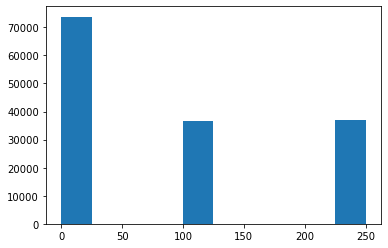

In [284]:
plt.hist(df.loc[df['group']=='control', 'revenue']);

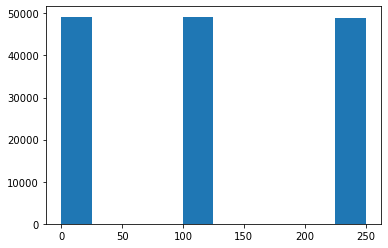

In [285]:
plt.hist(df.loc[df['group']=='treatment', 'revenue']);

**Вывод:** анализ диаграмм показывает, что количество покупок в тестовой группе выросло. Как следствие, сумма среднего чека возросла.

**Сделаем статистические выводы при помощи bootstrap-а**

In [286]:
a = df.loc[df['group']=='control', 'revenue'].values
b = df.loc[df['group']=='treatment', 'revenue'].values

In [287]:
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

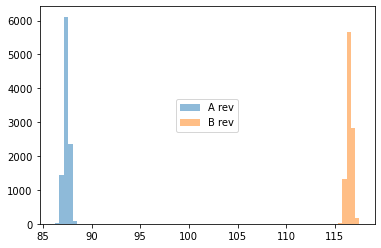

In [288]:
plt.hist(a_means, label='A rev', alpha=0.5, bins=5)
plt.hist(b_means, label='B rev', alpha=0.5, bins=5)

plt.legend(loc='center')
plt.show()

**Вывод:** из диаграммы видно, что любое среднее значение контрольной группы меньше любого среднего значения из тестовой группы.

**Найдем доверительные интервалы для оценки средних чеков со старой и новой версии сайта**

In [289]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(86.9067505876279, 87.94853330797136)

In [292]:
# доверительный интервал
np.percentile(b_means, 2.5), np.percentile(b_means, 97.5)

(115.97644898014612, 117.02384468616745)

Каждый из этих интервалов с заданной вероятностью накрывает истинное генеральное значение среднего чека со старой и новой версии сайта. Поскольку доверительный интервал контрольной группы на координатной прямой располагается левее аналогичного интервала для тестовой группы, то истинное генеральное значение среднего чека со старого сайта меньше аналогичного значения с нового. 

**Вывод:** средний чек со старого сайта меньше среднего чека с нового.

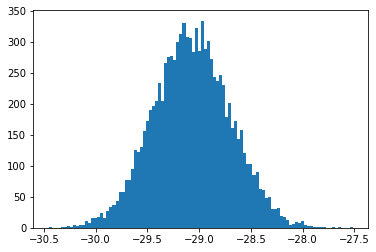

In [290]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [297]:
# сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.0

**Вывод:** любое выборочное среднее чеков со старого сайта меньше любого выборочного среднего чеков с нового сайта. Поскольку p_value = 0, то на любом уровне значимости будем отвергать нулевую гипотезу о равенстве генеральных средних чеков старого и нового сайтов.

**Итоговый вывод:** поскольку средний чек на сайте с новым дизайном статистически значимо больше среднего чека на сайте со старым дизайном, то статистически достоверно победивший вариант -- новый дизайт сайта.